**PRELIMINARY NOTEBOOK SETUP**

Various libraries and methods are being applied for this geospatial analysis and machine learning process. Public information from the government requires approval and integration through Google Cloud. Other libraries are pivotal for effective data visualization.

In [ ]:
# load necessary imports
%pip install google-cloud-bigquery-storage
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os

# Load credentials (adjust path as needed)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/callummagarian/Desktop/Machine-Learning-Final/credentials/file-name.json"
load_dotenv()

Note: you may need to restart the kernel to use updated packages.


False

In [2]:
# define BigQuery client
client = bigquery.Client(project="acs-dp05-03-analysis")
# query the full ACS census tract table:
query = """
SELECT *
FROM `bigquery-public-data.census_bureau_acs.censustract_2020_5yr`
"""

# run query
query_job = client.query(query)

acs_df = query_job.result().to_dataframe(create_bqstorage_client=False)

print("Loaded ACS dataframe with shape:", acs_df.shape)
acs_df.head()

Loaded ACS dataframe with shape: (85395, 245)


,geo_id,aggregate_travel_time_to_work,amerindian_including_hispanic,amerindian_pop,armed_forces,asian_including_hispanic,asian_male_45_54,asian_male_55_64,asian_pop,associates_degree,...,vacant_housing_units,vacant_housing_units_for_rent,vacant_housing_units_for_sale,walked_to_work,white_including_hispanic,white_male_45_54,white_male_55_64,white_pop,worked_at_home,workers_16_and_over
0,1001020200,18595.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,72.0,...,147.0,32.0,0.0,0.0,647.0,89.0,32.0,641.0,10.0,700.0
1,1001020300,47570.0,0.0,0.0,21.0,44.0,0.0,0.0,44.0,243.0,...,113.0,0.0,0.0,34.0,2363.0,143.0,232.0,2363.0,32.0,1959.0
2,1001020400,37660.0,10.0,10.0,10.0,17.0,0.0,0.0,17.0,257.0,...,105.0,23.0,25.0,28.0,3097.0,121.0,258.0,3085.0,45.0,1583.0
3,1001020503,28605.0,0.0,0.0,96.0,18.0,0.0,0.0,18.0,252.0,...,0.0,0.0,0.0,22.0,2397.0,218.0,105.0,2397.0,121.0,1606.0
4,1001020600,23255.0,0.0,0.0,40.0,11.0,0.0,0.0,11.0,145.0,...,134.0,43.0,22.0,6.0,2667.0,193.0,176.0,2551.0,80.0,1212.0


Below, the most relevant DP03 dataset columns will be applied which represents the economic data gathered from US households using the ACS.

In [3]:
# list of DP03 strings
dp03_cols = [
    'median_income', 'income_per_capita', 'poverty', 'pop_in_labor_force', 'employed_pop', 
    'unemployed_pop', 'not_in_labor_force', 'commuters_16_over', 'aggregate_travel_time_to_work', 
    'commute_less_10_mins', 'commute_5_9_mins', 'commute_10_14_mins', 'commute_15_19_mins', 
    'commute_20_24_mins', 'commute_25_29_mins', 'commute_30_34_mins', 'commute_35_39_mins', 
    'commute_40_44_mins', 'commute_45_59_mins', 'commute_60_more_mins', 'worked_at_home', 
    'walked_to_work', 'no_car', 'one_car', 'two_cars', 'three_cars', 'four_more_cars', 'gini_index'
]
dp03_df = acs_df[["geo_id"] + dp03_cols].copy()
dp03_df.head()


,geo_id,median_income,income_per_capita,poverty,pop_in_labor_force,employed_pop,unemployed_pop,not_in_labor_force,commuters_16_over,aggregate_travel_time_to_work,...,commute_45_59_mins,commute_60_more_mins,worked_at_home,walked_to_work,no_car,one_car,two_cars,three_cars,four_more_cars,gini_index
0,1001020200,49144.0,22772.0,257.0,729.0,688.0,29.0,721.0,690.0,18595.0,...,58.0,16.0,10.0,0.0,26.0,226.0,199.0,56.0,35.0,0.3746
1,1001020300,62423.0,25291.0,533.0,2015.0,1941.0,53.0,915.0,1927.0,47570.0,...,184.0,126.0,32.0,34.0,6.0,443.0,391.0,371.0,104.0,0.3604
2,1001020400,64310.0,47056.0,281.0,1668.0,1619.0,39.0,1391.0,1538.0,37660.0,...,56.0,109.0,45.0,28.0,68.0,590.0,661.0,298.0,15.0,0.5588
3,1001020503,81165.0,40522.0,319.0,1670.0,1547.0,27.0,1134.0,1485.0,28605.0,...,0.0,0.0,121.0,22.0,0.0,615.0,510.0,104.0,41.0,0.4089
4,1001020600,43030.0,24783.0,831.0,1263.0,1189.0,34.0,1548.0,1132.0,23255.0,...,37.0,47.0,80.0,6.0,0.0,461.0,446.0,307.0,99.0,0.4760


**CLEAN DATA**

Since our goal is to find socio-economic patterns using demographic data, using existing columns to create new columns is useful for identifying specific trends.

In [4]:
# create high burden rent target
acs_df['high_rent_burden'] = acs_df['percent_income_spent_on_rent'] >= 30
acs_df['high_rent_burden'].head()

0     True
1    False
2    False
3    False
4    False
Name: high_rent_burden, dtype: bool

In [5]:
# Dim and shape
acs_df.shape
acs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85395 entries, 0 to 85394
Columns: 246 entries, geo_id to high_rent_burden
dtypes: bool(1), float64(244), object(1)
memory usage: 159.7+ MB


Sentinal values are not useful in this analysis so they will be replaced.

In [6]:
# handlingsentinel codes
sentinel_values = [-666666666, -777777777, -888888888, -999999999]
acs_df.replace(sentinel_values, pd.NA, inplace=True)

In [7]:
# visualize by county
acs_df["county_fips"] = acs_df["geo_id"].str[:5]

In [8]:
# examine data types
acs_df.dtypes

geo_id                            object
aggregate_travel_time_to_work     object
amerindian_including_hispanic    float64
amerindian_pop                   float64
armed_forces                     float64
                                  ...   
white_pop                        float64
worked_at_home                   float64
workers_16_and_over              float64
high_rent_burden                    bool
county_fips                       object
Length: 247, dtype: object

Adjustments of certain values to be numeric will make encoding easier for the program.

In [9]:
# convert some columns to numeric
acs_df["geo_id"] = acs_df["geo_id"].astype(str)
acs_df["county_fips"] = acs_df["county_fips"].astype(str)
acs_df["high_rent_burden"] = acs_df["high_rent_burden"].astype(int)
acs_df["gini_index"] = pd.to_numeric(acs_df["gini_index"], errors='coerce')
acs_df["income_per_capita"] = pd.to_numeric(acs_df["income_per_capita"], errors='coerce')
acs_df["median_age"] = pd.to_numeric(acs_df["median_age"], errors='coerce')
acs_df["median_income"] = pd.to_numeric(acs_df["median_income"], errors='coerce')
acs_df["median_rent"] = pd.to_numeric(acs_df["median_rent"], errors='coerce')
acs_df["median_year_structure_built"] = pd.to_numeric(acs_df["median_year_structure_built"], errors='coerce')
acs_df["owner_occupied_housing_units_lower_value_quartile"] = pd.to_numeric(acs_df["owner_occupied_housing_units_lower_value_quartile"], errors='coerce')
acs_df["owner_occupied_housing_units_median_value"] = pd.to_numeric(acs_df["owner_occupied_housing_units_median_value"], errors='coerce')
acs_df["owner_occupied_housing_units_upper_value_quartile"] = pd.to_numeric(acs_df["owner_occupied_housing_units_upper_value_quartile"], errors='coerce')
acs_df["percent_income_spent_on_rent"] = pd.to_numeric(acs_df["percent_income_spent_on_rent"], errors='coerce')
acs_df["renter_occupied_housing_units_paying_cash_median_gross_rent"] = pd.to_numeric(acs_df["renter_occupied_housing_units_paying_cash_median_gross_rent"], errors='coerce')

In [10]:
# get ride of dominating, useless columns
acs_df["unemployment_rate"] = acs_df["unemployed_pop"] / acs_df["civilian_labor_force"]
acs_df["vacancy_rate"] = acs_df["vacant_housing_units"] / acs_df["occupied_housing_units"]
acs_df["renter_share"] = acs_df["housing_units_renter_occupied"] / acs_df["occupied_housing_units"]

Some values are seemingly infinite so they will be replaced in a manner similar to the sentinel values.

In [11]:
# replace infinite values for imputation
acs_df['percent_bachelors_or_higher'] = (acs_df['bachelors_degree_or_higher_25_64'] / acs_df['pop_25_64']).replace([np.inf, -np.inf], np.nan)
acs_df['children_per_adult'] = (acs_df['children'] / (acs_df['total_pop'] - acs_df['children'])).replace([np.inf, -np.inf], np.nan)
acs_df['non_white_percent'] = ((acs_df['total_pop'] - acs_df['white_pop']) / acs_df['total_pop']).replace([np.inf, -np.inf], np.nan)
acs_df.replace([np.inf, -np.inf], np.nan, inplace=True)

**DATA EXPLORATION**

In [12]:
# numeric summary statistics
print(acs_df.describe().T)

                                 count        mean         std  min       25%  \
amerindian_including_hispanic  85395.0   31.551156  166.373448  0.0  0.000000   
amerindian_pop                 85395.0   24.310592  160.260085  0.0  0.000000   
armed_forces                   85395.0   13.416664  150.199230  0.0  0.000000   
asian_including_hispanic       85395.0  215.791545  455.530673  0.0  2.000000   
asian_male_45_54               85395.0   13.852767   37.351118  0.0  0.000000   
...                                ...         ...         ...  ...       ...   
vacancy_rate                   84274.0    0.163153    0.427094  0.0  0.045182   
renter_share                   84274.0    0.357466    0.235832  0.0  0.171120   
percent_bachelors_or_higher    84489.0    0.330754    0.208757  0.0  0.167791   
children_per_adult             84521.0    0.289201    0.126986  0.0  0.213708   
non_white_percent              84522.0    0.397492    0.302941  0.0  0.135122   

                           

In [13]:
# check for remaining missing values
print(acs_df.isnull().sum())

geo_id                               0
aggregate_travel_time_to_work    39014
amerindian_including_hispanic        0
amerindian_pop                       0
armed_forces                         0
                                 ...  
vacancy_rate                      1121
renter_share                      1121
percent_bachelors_or_higher        906
children_per_adult                 874
non_white_percent                  873
Length: 253, dtype: int64


Below are a few general statistics of important features.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 4.6 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 6.2 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━ 3/8 [fonttools]]  WARNING: The scripts fonttools, pyftmerge, pyftsubset and ttx are installed in '/Library/Frameworks/Python.framework/Versions/3.13/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [seaborn]m7/8 [seaborn]ib]
Note: you may need to restart the kernel to use updated packages.


Matplotlib is building the font cache; this may take a moment.


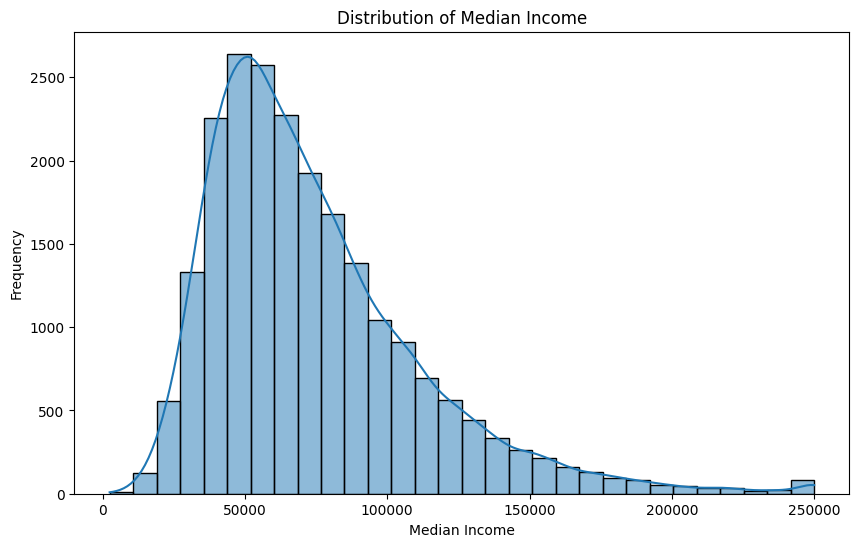

In [16]:
# import relevant visualization libraries
%pip install seaborn matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# distribution of median income
plt.figure(figsize=(10, 6))
sns.histplot(acs_df['median_income'].dropna(), bins=30, kde=True)
plt.title('Distribution of Median Income')
plt.xlabel('Median Income')
plt.ylabel('Frequency')
plt.show()

The distribution of median income has a right skewed, unimodal distribution which is logical. More people exist in middle and lower classes compared to the amount of wealth individuals across the United States.

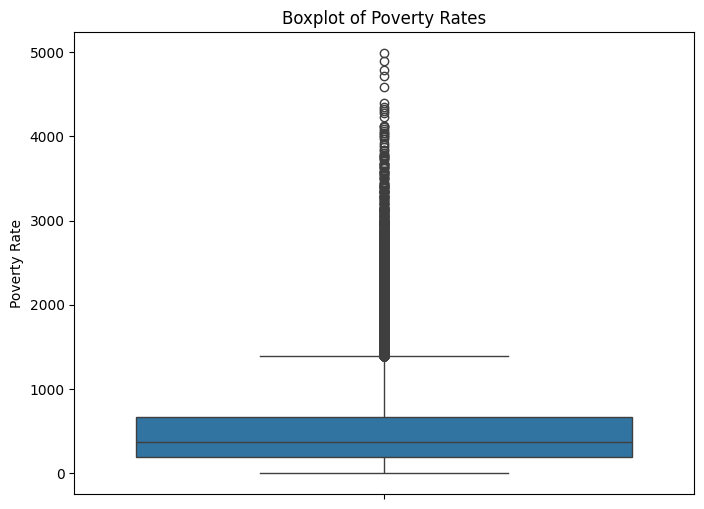

In [17]:
# boxplot of poverty rates
plt.figure(figsize=(8, 6))
sns.boxplot(y=acs_df['poverty'].dropna())
plt.title('Boxplot of Poverty Rates')
plt.ylabel('Poverty Rate')
plt.show()

Poverty rates demonstrate an even more significant right skew. Some extra measures were taken to make sure this distribution was not driven by error.

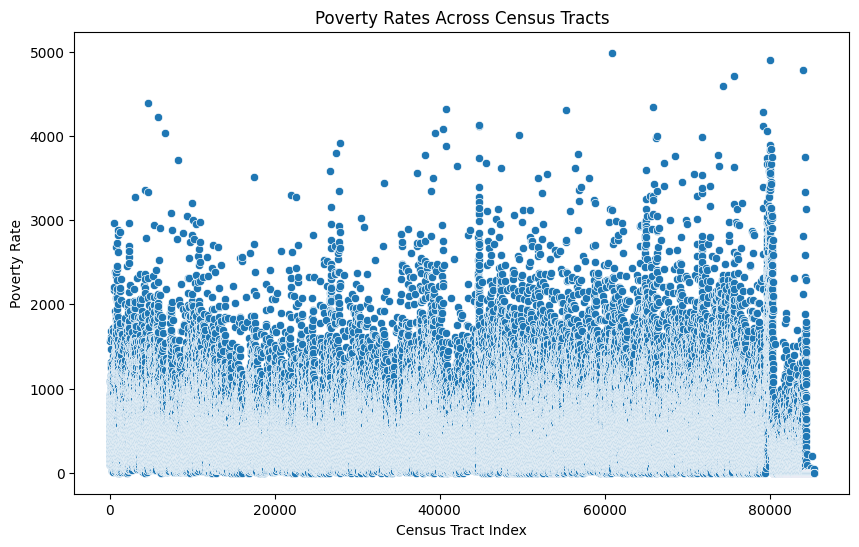

In [20]:
# tracking poverty outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x=acs_df.index, y=acs_df['poverty'])
plt.title('Poverty Rates Across Census Tracts')
plt.xlabel('Census Tract Index')
plt.ylabel('Poverty Rate')
plt.show()

In [22]:
# check poverty value range
print("Min:", acs_df['poverty'].min())
print("Max:", acs_df['poverty'].max())
print(acs_df['poverty'].describe())

Min: 0.0
Max: 4990.0
count    85395.000000
mean       495.477300
std        446.301212
min          0.000000
25%        187.000000
50%        370.000000
75%        667.000000
max       4990.000000
Name: poverty, dtype: float64


Based on these findings, the right skew for poverty rates appears to be justified.
Now, here are some evaluations of correlations and relationships between features.

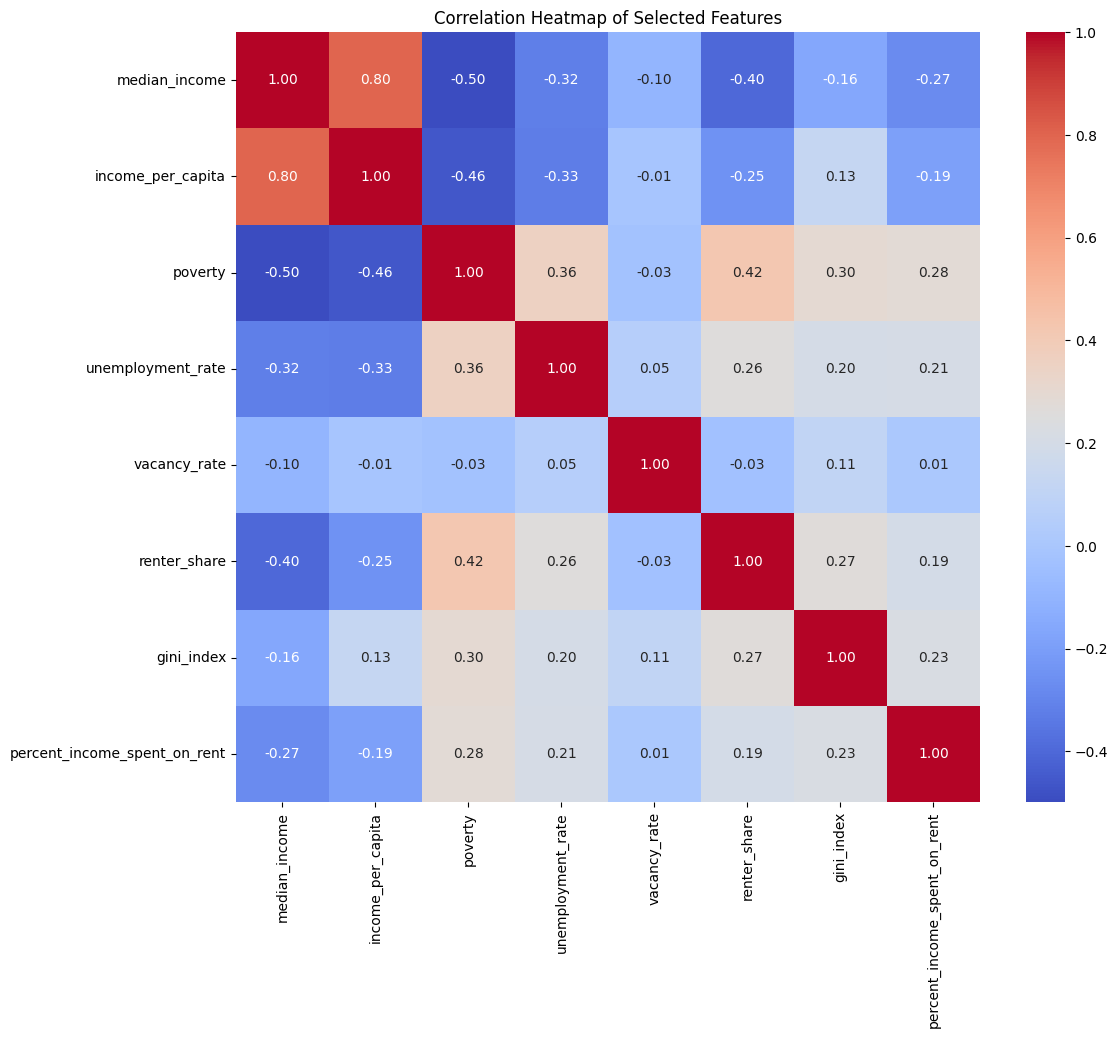

In [18]:
# correlation heatmap for top features
plt.figure(figsize=(12, 10))
top_cols = ['median_income', 'income_per_capita', 'poverty', 'unemployment_rate', 'vacancy_rate', 'renter_share', 'gini_index', 'percent_income_spent_on_rent']
corr_matrix = acs_df[top_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Selected Features')
plt.show()

Income per capita is heavily related to median income which makes sense given they are similar measurements. Otherwise, renter share and poverty have strong correlation as well as unemployment rate to poverty. The other features have varying degrees of relatability from solid to very little correlation.

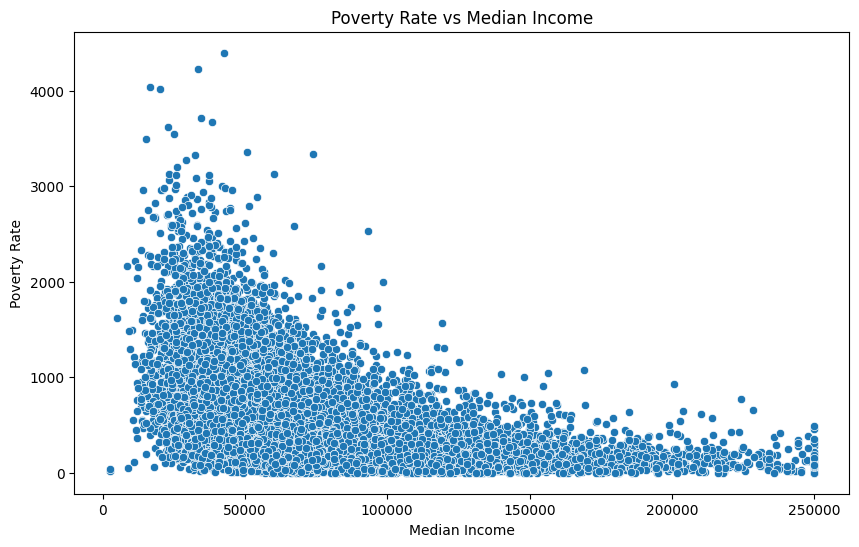

In [26]:
# poverty vs median income scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=acs_df['median_income'], y=acs_df['poverty'])
plt.title('Poverty Rate vs Median Income')
plt.xlabel('Median Income')
plt.ylabel('Poverty Rate')
plt.show()

Comparing median income with poverty rate does not show a linear trajectory, but still does show a strong relationship with higher income indicating less likelihood of poverty.
Following this is some employment and labor force analysis.

In [27]:
# calculate labor force participation and unemployment
acs_df['labor_force_participation'] = acs_df['civilian_labor_force'] / acs_df['total_pop'] * 100
# compare populations
summary_df = acs_df[['employed_pop', 'unemployed_pop', 'not_in_labor_force', 'labor_force_participation']]
print(summary_df.describe())

       employed_pop  unemployed_pop  not_in_labor_force  \
count  33525.000000    85395.000000        85395.000000   
mean    1868.553199      106.009567         1139.000515   
std      895.767267       90.485234          580.653925   
min        0.000000        0.000000            0.000000   
25%     1234.000000       44.000000          756.000000   
50%     1784.000000       84.000000         1064.000000   
75%     2416.000000      143.000000         1433.000000   
max     9711.000000     1459.000000        11549.000000   

       labor_force_participation  
count               84522.000000  
mean                   50.027469  
std                     9.714509  
min                     0.000000  
25%                    44.892512  
50%                    50.412512  
75%                    55.561728  
max                   100.000000  


In [30]:
# finding high unemployment tracts
high_unemp = acs_df[acs_df['unemployment_rate'] > acs_df['unemployment_rate'].quantile(0.95)]
print("High unemployment tracts shape:", high_unemp.shape)
print(high_unemp[['geo_id', 'unemployment_rate', 'median_income', 'poverty']].head())

High unemployment tracts shape: (4219, 254)
         geo_id  unemployment_rate  median_income  poverty
33   1007010005           0.166588        57218.0    540.0
68   1023956700           0.163906        37823.0    833.0
72   1025957901           0.236061        43409.0    779.0
105  1039961900           0.154472        58958.0    255.0
134  1047956900           0.189349        27216.0   1154.0


There are various areas that are considered to have high unemployment, but is still a relatively small value given all of the included locations.
Next is a quick evaluation of commuting patterns and transportation equity.

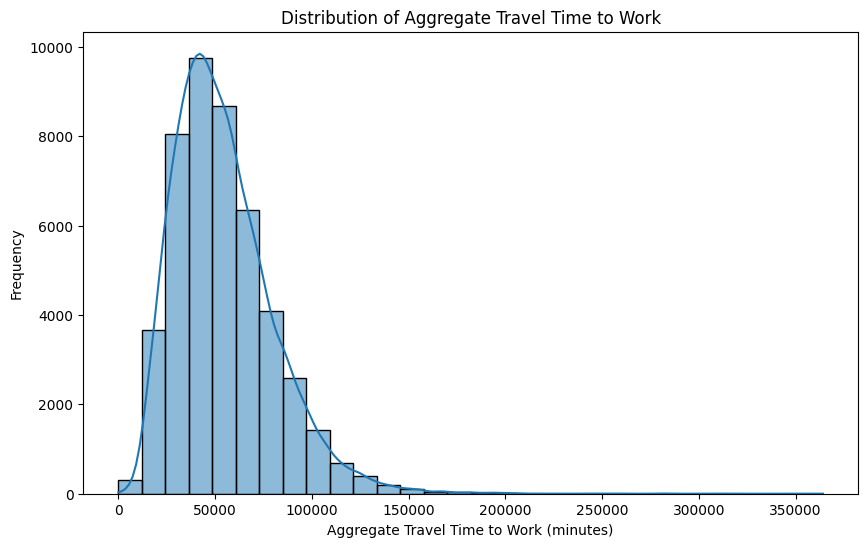

In [33]:
# distributuion of commute times histogram
plt.figure(figsize = (10, 6))
sns.histplot(acs_df['aggregate_travel_time_to_work'].dropna(), bins = 30, kde = True)
plt.title('Distribution of Aggregate Travel Time to Work')
plt.xlabel('Aggregate Travel Time to Work (minutes)')
plt.ylabel('Frequency')
plt.show()


In [34]:
# commute segments example
commute_segments = ['commute_less_10_mins', 'commute_5_9_mins', 'commute_10_14_mins', 'commute_15_19_mins', 'commute_20_24_mins', 'commute_25_29_mins', 'commute_30_34_mins', 'commute_35_39_mins', 'commute_40_44_mins', 'commute_45_59_mins', 'commute_60_more_mins', 'worked_at_home']
commute_summary = acs_df[commute_segments].sum().sort_values()
print("Commute Segments Summary:\n", commute_summary)

Commute Segments Summary:
 commute_20_24_mins       1504257.0
commute_35_39_mins       4469225.0
commute_40_44_mins       5744545.0
commute_25_29_mins       9418349.0
worked_at_home          11183812.0
commute_45_59_mins      11958136.0
commute_60_more_mins    13305105.0
commute_5_9_mins        13574762.0
commute_less_10_mins    17610025.0
commute_10_14_mins      18951876.0
commute_30_34_mins      19742538.0
commute_15_19_mins      21766014.0
dtype: float64


In [35]:
# long commutes with low income
long_commute_low_income = acs_df[(acs_df['aggregate_travel_time_to_work'] > acs_df['aggregate_travel_time_to_work'].quantile(0.75)) & (acs_df['median_income'] < acs_df['median_income'].quantile(0.25))]
print("Long Commute with Low Income shape:", long_commute_low_income.shape)
print(long_commute_low_income[['geo_id', 'aggregate_travel_time_to_work', 'median_income']].head())

Long Commute with Low Income shape: (317, 254)
         geo_id aggregate_travel_time_to_work  median_income
114  1043964100                       75980.0        34661.0
173  1055011100                       77340.0        39345.0
230  1073005905                       70710.0        44903.0
462  1117030212                       73445.0        44104.0
692  4013071910                       77220.0        46704.0


While there are areas that disproptionately have high travel times with lower income, it is more the exception than it is the norm.

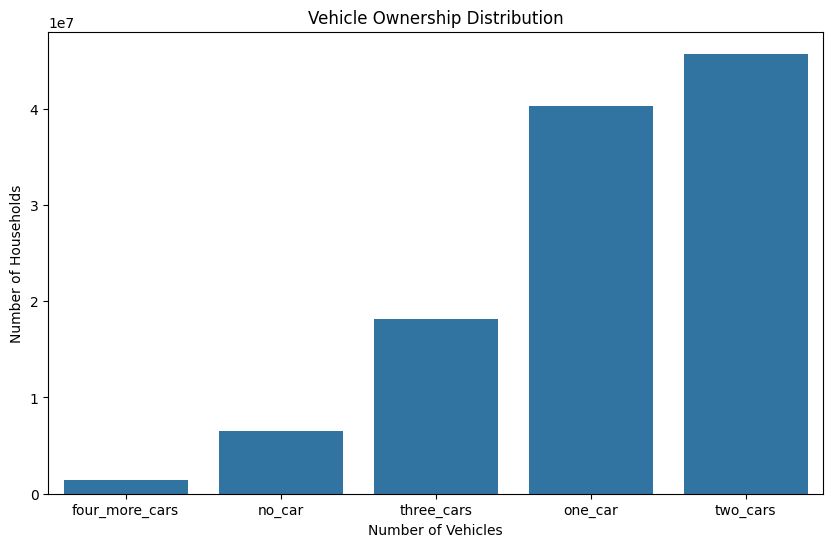

In [36]:
# vehicle ownership distribution histogram
vehicle_ownership = ['no_car', 'one_car', 'two_cars', 'three_cars', 'four_more_cars']
vehicle_summary = acs_df[vehicle_ownership].sum().sort_values()
plt.figure(figsize=(10, 6))
sns.barplot(x=vehicle_summary.index, y=vehicle_summary.values)
plt.title('Vehicle Ownership Distribution')
plt.xlabel('Number of Vehicles')
plt.ylabel('Number of Households')
plt.show()

In [37]:
# corss reference vehicle ownership with income levels
income_bins = pd.qcut(acs_df['median_income'], q=4, labels=['Low', 'Lower-Middle', 'Upper-Middle', 'High'])
acs_df['income_level'] = income_bins
vehicle_income_crosstab = pd.crosstab(acs_df['income_level'], acs_df[vehicle_ownership].idxmax(axis=1))
print("Vehicle Ownership by Income Level:\n", vehicle_income_crosstab)

Vehicle Ownership by Income Level:
 col_0         four_more_cars  no_car  one_car  three_cars  two_cars
income_level                                                       
Low                        5      83     3811          34      1562
Lower-Middle               9      22     2332         107      3034
Upper-Middle              52      24     1394         177      3839
High                      50      66      756         186      4437


There is an intuitive relationship indicating that the more wealthy a household is, the more likely they are to own more cars.

Then, there will be some income inequality analysis.

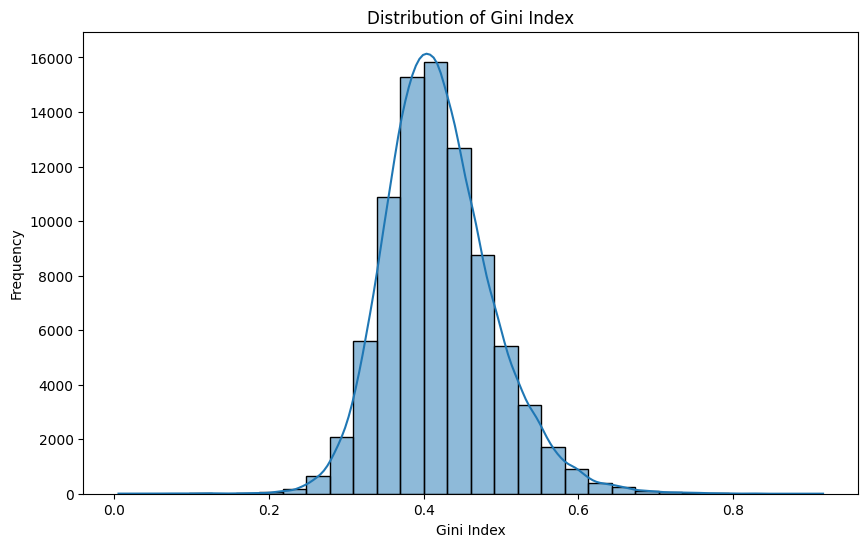

In [38]:
# gini index distribution histogram
plt.figure(figsize=(10, 6))
sns.histplot(acs_df['gini_index'].dropna(), bins = 30, kde = True)
plt.title('Distribution of Gini Index')
plt.xlabel('Gini Index')
plt.ylabel('Frequency')
plt.show()

The gini index has a normal distribution which indicates a standard level of poverty and wealth in Rhode Island relative to the United States overall.

In [39]:
# flagging high inequality tracts
high_gini = acs_df[acs_df['gini_index'] > acs_df['gini_index'].quantile(0.95)]
print("High Gini Index tracts shape:", high_gini.shape)
print(high_gini[['geo_id', 'gini_index', 'median_income', 'poverty']].head())

High Gini Index tracts shape: (4209, 255)
         geo_id  gini_index  median_income  poverty
2    1001020400      0.5588        64310.0    281.0
43   1009050702      0.5731        24375.0    668.0
110  1041963400      0.5455        43149.0    217.0
154  1051031200      0.5572        39643.0    438.0
208  1069041400      0.5581        27500.0   1083.0


Looking at hihg inequality tracts, even the first listed ones do not appear to have high oncome inequality. The numeric values vary by population per area but the proportions do not signficantly change between tracts.